In [154]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Week1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.datasets import cifar10
import os
import cv2
import random

In [0]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()

In [0]:
#load 7000 images from LFW, please note that this process takes a very long time
def take_lfw(number):
  from skimage.io import imread_collection
  flag = False
  total_lfw_img = []
  subfolders = [f.path for f in os.scandir(r'Week1/LFW/lfw') if f.is_dir()] 
  random.shuffle(subfolders)
  count = 0
  for subfolder in subfolders:
    col_dir = subfolder + r'/*.jpg'
    col = imread_collection(col_dir)
    for image in col:
      img_resize = cv2.resize(image,(32,32),interpolation = cv2.INTER_CUBIC)
      img_resize = img_resize.reshape((3072,1)).T
      total_lfw_img.append(img_resize)
      count += 1
      if (count == number):
        flag = True
        break
    if (flag == True):
      break
  file.close()
  return total_lfw_img


total_lfw_img = take_lfw(7000)

In [0]:
#write data to .pickle file
import pickle
file = open("dict.pickle","wb")
pickle.dump(total_lfw_img,file)
file.close()

In [157]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

#load the .pickle file
lfwdata = unpickle('dict.pickle')
print(lfwdata)

[array([[ 0,  0,  1, ..., 26, 23, 18]], dtype=uint8), array([[181, 164,  72, ...,  54,  49,  68]], dtype=uint8), array([[103, 117,  95, ..., 155,  72,  90]], dtype=uint8), array([[242, 237, 229, ..., 200, 207, 199]], dtype=uint8), array([[ 0,  0,  1, ..., 56, 44, 45]], dtype=uint8), array([[ 0,  0,  0, ..., 66, 73, 50]], dtype=uint8), array([[0, 0, 0, ..., 5, 1, 1]], dtype=uint8), array([[  7,   8,   7, ..., 186, 154, 131]], dtype=uint8), array([[ 0,  0,  0, ..., 21, 17, 18]], dtype=uint8), array([[49, 32,  4, ..., 29, 26, 19]], dtype=uint8), array([[ 0,  1,  0, ..., 64, 72, 72]], dtype=uint8), array([[ 0,  0,  0, ..., 28, 19, 20]], dtype=uint8), array([[182, 163, 139, ..., 240, 221, 179]], dtype=uint8), array([[41, 19,  6, ..., 83, 69, 42]], dtype=uint8), array([[190, 180, 152, ...,  33,  39,  36]], dtype=uint8), array([[ 80,  76,  60, ..., 179, 148, 104]], dtype=uint8), array([[ 34,  29,  36, ..., 206, 155, 112]], dtype=uint8), array([[ 77,  48,  52, ..., 107, 127, 125]], dtype=uint8

In [0]:
#split the lfw data into train dataset and test dataset
x_lfw_train = lfwdata[0:5000]
x_lfw_test = lfwdata[5000:7000]

In [0]:
#combine cifar10 and lfw into cifar11 
x_train_cifar11 = x_train_cifar10.reshape((x_train_cifar10.shape[0],-1))
x_test_cifar11 = x_test_cifar10.reshape((x_test_cifar10.shape[0],-1))
for i in range(5000):
  x_train_cifar11 = np.vstack((x_train_cifar11,x_lfw_train[i]))
  y_train_cifar10 = np.vstack((y_train_cifar10,[10]))
for i in range(2000):
  x_test_cifar11 = np.vstack((x_test_cifar11,x_lfw_test[i]))
  y_test_cifar10 = np.vstack((y_test_cifar10,[10]))

In [160]:
#reshape into original shape
x_train = np.array([arr.reshape((32,32,3)) for arr in x_train_cifar11])
x_test = np.array([arr.reshape((32,32,3)) for arr in x_test_cifar11])

print(x_train.shape)
print(y_train_cifar10.shape)
print(x_test.shape)
print(y_test_cifar10.shape)

(55000, 32, 32, 3)
(55000, 1)
(12000, 32, 32, 3)
(12000, 1)


In [161]:
#complete (x_train, y_train),(x_test,y_test)
shuffle_index_train = np.arange(55000)
shuffle_index_test = np.arange(12000)
random.shuffle(shuffle_index_train)
random.shuffle(shuffle_index_test)

x_train = np.array([x_train[i] for i in shuffle_index_train])
y_train = np.array([y_train_cifar10[i] for i in shuffle_index_train])
x_test = np.array([x_test[i] for i in shuffle_index_test])
y_test = np.array([y_test_cifar10[i] for i in shuffle_index_test])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(55000, 32, 32, 3)
(55000, 1)
(12000, 32, 32, 3)
(12000, 1)


In [0]:
# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Mean subtraction
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert labels to categorical one-hot encoding
train_labels = keras.utils.to_categorical(y_train, num_classes=11)
test_labels = keras.utils.to_categorical(y_test, num_classes=11)

In [0]:
#Model 1:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(11, activation='softmax'))

adam = optimizers.Adam(lr=0.001)
cnn_model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [171]:
history = cnn_model.fit(x_train, train_labels, validation_data=(x_test, test_labels),
          epochs=100, batch_size=512)
score = cnn_model.evaluate(x_test, test_labels, batch_size = 512)
print("Test loss: "+str(score[0]))
print("Test accuracy: "+str(score[1]))

Train on 55000 samples, validate on 12000 samples
Epoch 1/100
55000/55000 [==============================] - 2s 37us/step - loss: 0.9404 - acc: 0.6718 - val_loss: 0.9369 - val_acc: 0.6722
Epoch 2/100
55000/55000 [==============================] - 2s 34us/step - loss: 0.9359 - acc: 0.6721 - val_loss: 0.9349 - val_acc: 0.6684
Epoch 3/100
55000/55000 [==============================] - 2s 34us/step - loss: 0.9361 - acc: 0.6730 - val_loss: 0.9394 - val_acc: 0.6697
Epoch 4/100
55000/55000 [==============================] - 2s 34us/step - loss: 0.9294 - acc: 0.6737 - val_loss: 0.9225 - val_acc: 0.6763
Epoch 5/100
55000/55000 [==============================] - 2s 34us/step - loss: 0.9252 - acc: 0.6765 - val_loss: 0.9318 - val_acc: 0.6746
Epoch 6/100
55000/55000 [==============================] - 2s 34us/step - loss: 0.9262 - acc: 0.6751 - val_loss: 0.9151 - val_acc: 0.6805
Epoch 7/100
55000/55000 [==============================] - 2s 34us/step - loss: 0.9211 - acc: 0.6775 - val_loss: 0.9139 - 

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

In [0]:
epochs = range(1, 101)

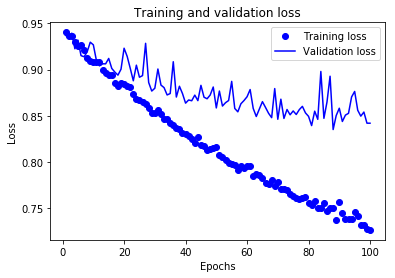

In [173]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

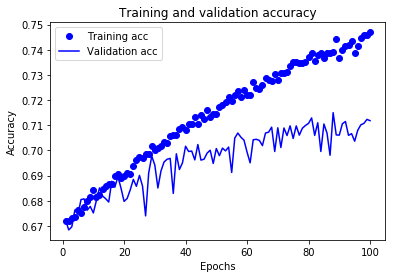

In [174]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()